In [1]:
# ORIGINAL RGB FILE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

from matplotlib import rc
rc("font", family="serif", size=11)

In [58]:
output = pd.read_csv('../data/output_1000stars.csv', usecols=range(1,4))
ID = 11083319
#ID = random.choice(output['ID'])
star = output.loc[(output['ID'] == ID)]

star



,ID,Numax,Numax_err
259,11083319,44.015084,2.727756


In [85]:
modes = pd.read_csv('../data/rgbmodes/modes_'+str(ID)+'.csv', usecols=['f0', 'f0_err', 'A0'])

modes = modes.sort_values(by=['f0'])
modes = modes.set_index(np.arange(0,len(modes),1))
modes['dnu'] = (modes['f0'].diff(2).shift(-1))/2
dnu_avg = np.mean(modes['dnu'])
n_min = int(modes['f0'].min() / dnu_avg)

n = np.arange(n_min, n_min+len(modes), 1)
modes.insert(loc=0, column='n', value=n)


modes

,n,f0,A0,f0_err,dnu
0,7,33.385122,-0.185618,0.030268,NaN
1,8,37.450272,0.185182,0.036264,4.056850
2,9,41.498822,0.342398,0.027044,4.161904
3,10,45.774079,0.172590,0.030813,4.224105
4,11,49.947033,0.540414,0.024758,4.217064
5,12,54.208207,0.197550,0.042612,4.301390
6,13,58.549813,-0.492480,0.088717,4.504210
7,14,63.216627,-1.507861,0.090662,NaN


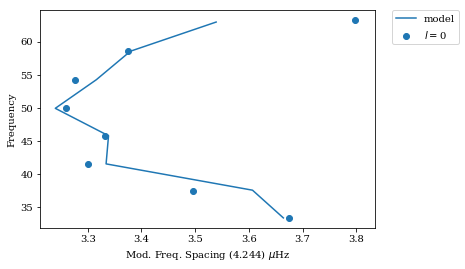

In [71]:
plt.scatter(modes['f0'] % dnu_avg, modes['f0'], label=r'$l=$'+str(0))

def model(n, dnu, nmax, epsilon, k, A, omega, phi, tau):
    freqs = (n + epsilon) * dnu
    freqs += (nmax-n)**2 * k
    freqs += A*np.sin(omega*n + phi)*np.exp(-n/tau)
    return freqs

nmax = 11
epsilon = 0.77
k = 0.03
A = 0.2
omega = 3
phi = 2
tau = 10

f = model(n, dnu_avg, nmax, epsilon, k, A, omega, phi, tau)

plt.plot(f % dnu_avg, f, label='model')
plt.ylabel('Frequency')
plt.xlabel(r'Mod. Freq. Spacing ('+ str(u"%.3f" % dnu_avg) +') $\mu$Hz')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [87]:
code = '''
functions {
    real model(real n, real dnu, real nmax, real epsilon, real k, real A, real omega, real phi, real tau){
        return (dnu*(n+epsilon) + k*(nmax - n)^2 + A*sin(omega*n + phi)*exp(-n/tau));
    }
}
data {
    int N;
    real n[N];
    real freq[N];
    real freq_err[N];
    real dnu_guess;
}
parameters {
    real<lower = 0> dnu;
    real<lower = 0> nmax;
    real epsilon;
    real k;
    real<lower = 0> A;
    real<lower = 0> omega;
    real<lower = -2.0*pi(), upper = 2.0*pi()> phi;
    real<lower = 0> tau;
}
model {
    real mod[N];
    for (i in 1:N){
        mod[i] = model(n[i], dnu, nmax, epsilon, k, A, omega, phi, tau);
    }
    mod ~ normal(freq, freq_err);
    dnu ~ normal(dnu_guess, dnu_guess*0.001);
    nmax ~ normal(11,2);
    epsilon ~ normal(0.77, 0.1);
    k ~ lognormal(log(0.03), 0.3);
    A ~ lognormal(log(0.2), 0.3);
    omega ~ normal(3, 0.5);
    tau ~ normal(10,5);
    // phi ~ normal(0, 1.5);
    
}
'''
import pystan
sm = pystan.StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_26f60c38e65fe186037548447b2d0a40 NOW.


In [88]:
stan_data = {'N': len(modes['n'].values),
             'n': modes['n'].values, 
             'freq': (modes['f0'].values),
             'freq_err': modes['f0_err'].values,
             'dnu_guess': dnu_avg
            }
start = {'dnu': dnu_avg,
         'nmax': nmax,
         'epsilon': epsilon,
         'k': k,
         'A': A,
         'omega': omega,
         'phi': phi,
         'tau': tau
        }
nchains = 4

fit = sm.sampling(data=stan_data, iter=5000, chains=nchains, init=[start for n in range(nchains)],)
                  #control=dict(max_treedepth=15))

In [89]:
print(fit)

Inference for Stan model: anon_model_26f60c38e65fe186037548447b2d0a40.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu       4.24  6.9e-5 4.1e-3   4.24   4.24   4.24   4.25   4.25   3636    1.0
nmax     10.59  2.6e-3   0.16   10.3  10.48  10.58  10.69  10.92   3583    1.0
epsilon   0.77  2.1e-4   0.01   0.75   0.76   0.77   0.78   0.79   3212    1.0
k         0.03  6.9e-5 3.7e-3   0.03   0.03   0.03   0.04   0.04   2842    1.0
A         0.18 10.0e-4   0.06    0.1   0.14   0.18   0.22   0.32   3201    1.0
omega     3.01    0.03   0.49   2.08   2.67   3.05   3.32   3.95    284   1.02
phi       0.07    0.19   3.65  -5.98  -3.06   0.04   3.29   6.02    371   1.01
tau       6.85    0.08   3.43   0.89   4.55   6.46   8.76  14.53   1673    1.0
lp__      2.32    0.06   2.45  -3.57   0.94   2.76   4.12   5.87   1717    1.0

Samples were drawn 

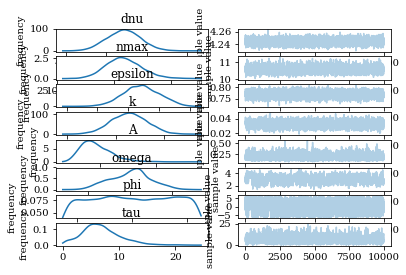

In [90]:
fit.plot()
plt.show()

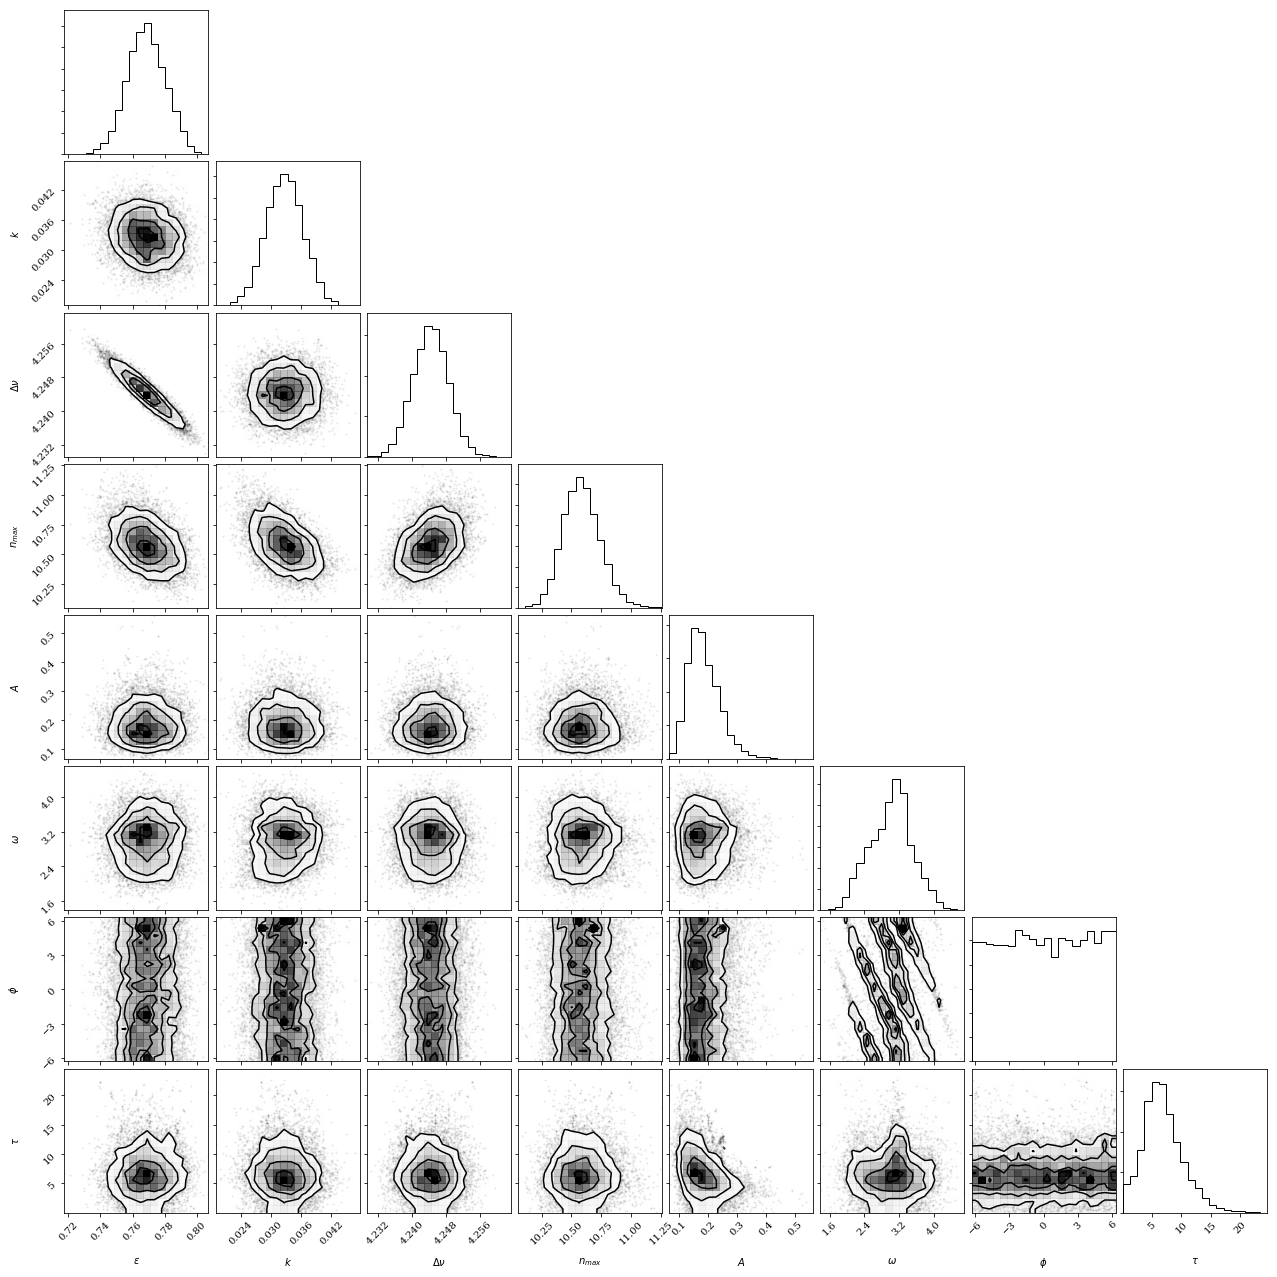

In [91]:
import corner
data = np.vstack([fit['epsilon'], fit['k'], fit['dnu'], fit['nmax'],
                  fit['A'], fit['omega'], fit['phi'], fit['tau']]).T
corner.corner(data, labels=[r'$\epsilon$', r'$k$',r'$\Delta\nu$',r'$n_{max}$',
                            r'$A$', r'$\omega$', r'$\phi$', r'$\tau$'])
              #, truths=[1.436, 0.07, 0.3, 2, 0])
plt.show()

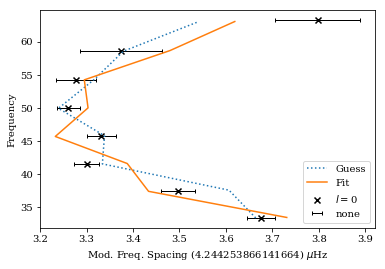

In [92]:
#n = np.arange(12,30,1)

plt.figure(4)
plt.scatter(modes['f0'] % dnu_avg, modes['f0'], c='k', marker='x', label=r'$l=$'+str(0))
plt.errorbar(modes['f0'] % dnu_avg, modes['f0'], xerr=modes['f0_err'], zorder=0, fmt="none", label="none",
             c='k', capsize=2, markersize=4, elinewidth=1)

g = model(n, fit['dnu'].mean(), fit['nmax'].mean(), fit['epsilon'].mean(), fit['k'].mean(),
          fit['A'].mean(), fit['omega'].mean(), fit['phi'].mean(), fit['tau'].mean())
plt.plot(f % dnu_avg, f, ':', label='Guess')
plt.plot(g % fit['dnu'].mean(), g, label='Fit')
#plt.plot(g % dnu, g, label='Fit')

plt.ylabel('Frequency')
plt.xlabel(r'Mod. Freq. Spacing ('+ str(dnu_avg) +') $\mu$Hz')
#plt.xlim(58,68)
plt.legend()
plt.show()